<a href="https://colab.research.google.com/github/A01364577/Equipo_18_Navegacion_Autonoma/blob/main/deteccion_de_peatones_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Maestria en Inteligencia Artificial Aplicada
##Navegación Autónoma
###Actividad 4.1 - Ejercicio de clasificación con Keras
Equipo 18:

- Laura Irán González Ojeda - A01794099
- Emmanuel Francisco González Velázquez - A01364577
- Fabiola Sosa Hernández- A01240145
- Jorge Fernández Lara - A01793062
- Jonathan Puga Castellanos - A01795204

In [1]:
# Asegurarse de que se esté utilizando GPU
import tensorflow as tf
tf.test.gpu_device_name()

# Importación de Librerías
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from xml.etree import ElementTree
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.feature import hog
import numpy as np

In [2]:
# Verificar si hay una GPU disponible
if tf.config.list_physical_devices('GPU'):
    print("GPU está disponible.")
    # Obtener detalles de la GPU
    for gpu in tf.config.list_physical_devices('GPU'):
        print(f"Nombre de la GPU: {gpu.name}")
else:
    print("No hay GPU disponible.")

GPU está disponible.
Nombre de la GPU: /physical_device:GPU:0


In [3]:
# Cargar el archivo .json con el token de Kaggle y utilizar la API de Kaggle para descargar el archivo .zip del dataset
from google.colab import files
files.upload()

# Crear el directorio .kaggle y mover el archivo kaggle.json allí
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Instalar la API de Kaggle
!pip install kaggle

# Descargar el archivo del conjunto de datos de Kaggle
!kaggle datasets download -d karthika95/pedestrian-detection --unzip -p /content/pedestrian_dataset

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/karthika95/pedestrian-detection
License(s): unknown
 95% 177M/187M [00:01<00:00, 107MB/s]
100% 187M/187M [00:01<00:00, 113MB/s]


In [4]:
# Se definen los nombres de las clases
class_names = ['person', 'person-like']
class_names_label = {name: i for i, name in enumerate(class_names)}

# Se definen los parámetros de la imagen
n_classes = 2
size = (200, 200)

In [5]:
# Función para cargar y procesar las imágenes y etiquetas desde los directorios específicos para conjuntos de datos de entrenamiento, prueba y validación
def load_data():
    datasets = ['Train/Train', 'Test/Test', 'Val/Val']
    output = []

    for dataset in datasets:
        imags = []
        labels = []
        directoryA = "/content/pedestrian_dataset/" + dataset + "/Annotations"
        directoryIMG = "/content/pedestrian_dataset/" + dataset + "/JPEGImages/"
        file = os.listdir(directoryA)
        img = os.listdir(directoryIMG)
        file.sort()
        img.sort()

        i = 0
        for xml in file:
            xmlf = os.path.join(directoryA, xml)
            dom = ElementTree.parse(xmlf)
            vb = dom.findall('object')
            label = vb[0].find('name').text
            labels.append(class_names_label[label])

            img_path = directoryIMG + img[i]
            curr_img = cv2.imread(img_path)
            curr_img = cv2.resize(curr_img, size)
            imags.append(curr_img)
            i += 1

        imags = np.array(imags, dtype='float32')
        imags = imags / 255

        labels = np.array(labels, dtype='int32')
        output.append((imags, labels))
    return output


In [6]:
(train_images, train_labels), (test_images, test_labels), (val_images, val_labels) = load_data()

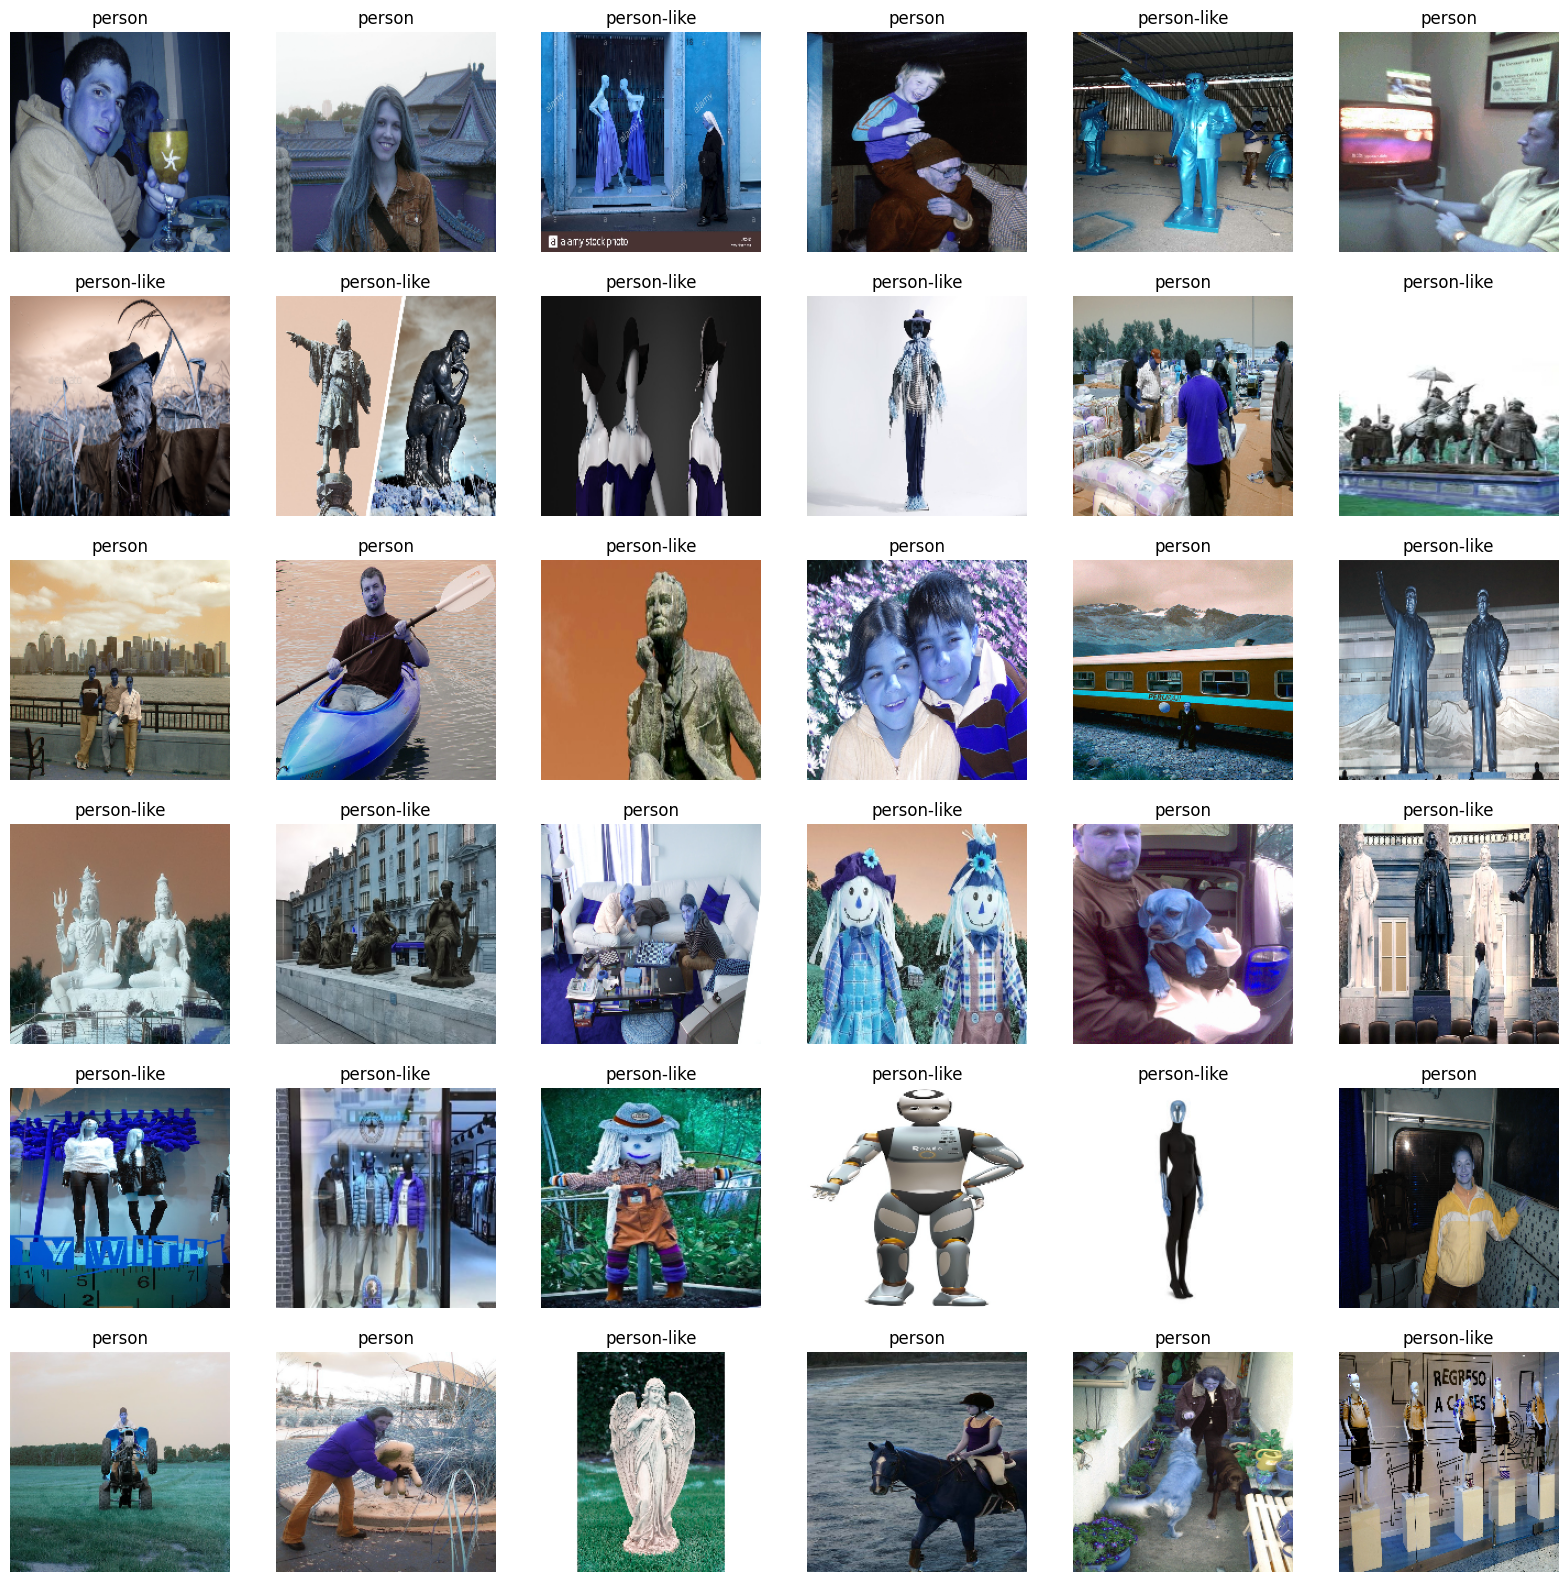

In [7]:
# Visualización de algunas imágenes
plt.figure(figsize=(20, 20))
for n, i in enumerate(list(np.random.randint(0, len(train_images), 36))):
    plt.subplot(6, 6, n+1)
    plt.imshow(train_images[i])
    plt.title(class_names[train_labels[i]])
    plt.axis('off')
plt.show()

In [8]:
# Extracción de HOG features
def extract_hog_features(images):
    hog_features_accum = []
    for img in images:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        features, hog_img = hog(img_gray,
                                orientations=12,
                                pixels_per_cell=(16, 16),
                                cells_per_block=(2, 2),
                                transform_sqrt=True,
                                visualize=True,
                                feature_vector=True)
        hog_features_accum.append(features)
    return np.vstack(hog_features_accum).astype(np.float64)

In [9]:
train_features = extract_hog_features(train_images)
test_features = extract_hog_features(test_images)
val_features = extract_hog_features(val_images)

In [10]:
print("Shape de train_features:", train_features.shape)
print("Shape de train_labels:", train_labels.shape)

Shape de train_features: (944, 5808)
Shape de train_labels: (944,)


In [44]:
# Normalización de los datos
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)
val_features = scaler.transform(val_features)

In [47]:
from sklearn.utils import class_weight
# Balancear clases
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = dict(enumerate(class_weights))

In [50]:
# Creación del modelo de red neuronal
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

In [72]:
model = Sequential()
#model.add(Dense(units=512, activation='relu', input_dim=train_features.shape[1]))
model.add(Dense(units=512, activation='relu', input_dim=train_features.shape[1], kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
#model.add(Dense(units=256, activation='relu', input_dim=train_features.shape[1]))
model.add(Dense(units=256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(units=64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(units=1, activation='sigmoid'))

In [75]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy', metrics=['accuracy'])

In [82]:
# Definir callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

In [83]:
epochs=20
batch_size=64
# Entrenamiento del modelo
history = model.fit(train_features,
                    train_labels,
                    validation_data=(val_features, val_labels),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    callbacks=[early_stopping, reduce_lr],
                    class_weight=class_weights_dict)

Epoch 1/20
15/15 [==============================] - 1s 20ms/step - loss: 0.5982 - accuracy: 0.8178 - val_loss: 0.7662 - val_accuracy: 0.6938 - lr: 1.0000e-04
Epoch 2/20
15/15 [==============================] - 0s 11ms/step - loss: 0.6051 - accuracy: 0.8093 - val_loss: 0.7556 - val_accuracy: 0.7063 - lr: 1.0000e-04
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 0.5939 - accuracy: 0.8284 - val_loss: 0.7763 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 0.5753 - accuracy: 0.8294 - val_loss: 0.7731 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 5/20
15/15 [==============================] - 0s 8ms/step - loss: 0.5810 - accuracy: 0.8220 - val_loss: 0.7746 - val_accuracy: 0.6625 - lr: 1.0000e-04
Epoch 6/20
15/15 [==============================] - 0s 8ms/step - loss: 0.5296 - accuracy: 0.8581 - val_loss: 0.7920 - val_accuracy: 0.6938 - lr: 1.0000e-04
Epoch 7/20
15/15 [==============================] - 0s 8

In [84]:
# Evaluación del modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_features, test_labels, batch_size=batch_size, verbose=1)
print("Test Accuracy: ", test_acc)

4/4 [==============================] - 0s 4ms/step - loss: 0.7360 - accuracy: 0.7191
Test Accuracy:  0.7191489338874817


In [85]:
# Predicción de etiquetas del conjunto de datos de prueba
test_predictions = (model.predict(test_features) > 0.5).astype("int32")

8/8 [==============================] - 0s 3ms/step


In [87]:
# Cálculo de la matriz de confusión y clasificación
conf_matrix = confusion_matrix(test_labels, test_predictions)
print(classification_report(test_labels, test_predictions))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       136
           1       0.67      0.65      0.66        99

    accuracy                           0.72       235
   macro avg       0.71      0.71      0.71       235
weighted avg       0.72      0.72      0.72       235



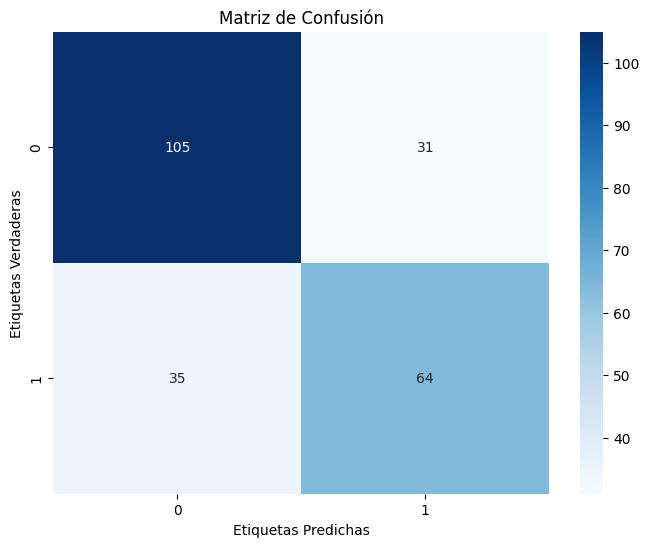

In [88]:
# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Matriz de Confusión')
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Verdaderas')
plt.show()